# Проект телекомуникации

***Описание проекта***:

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Цель проекта:

- Научиться предсказывать то, что клиенты хотят уйти и давать промокоды ил спец. условия.
- Целевая метрика `AUC-ROC` должна превышать `0.88`

### 1. Импорт библиотек

In [19]:
# Pandas
import pandas as pd
# Numpy
import numpy as np
# Matplotlib
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
# Datetime
import datetime as dt
from datetime import datetime 
# CatBoost
from catboost import CatBoostClassifier
# LightGBM
from lightgbm import LGBMClassifier
# Sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# Phik
from phik import phik_matrix

In [20]:
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (16, 9)
RANDOM_STATE = 161023
scorer = make_scorer(roc_auc_score, greater_is_better=True)

### 2. Предобработка данных

In [21]:
try:
    df_contract = pd.read_csv('contract_new.csv')#, parse_dates=['BeginDate'])#, date_format='%Y-%m-%d')
    df_personal = pd.read_csv('personal_new.csv')#, parse_dates=['BeginDate'])#, date_format='%Y-%m-%d')
    df_internet = pd.read_csv('internet_new.csv')#, parse_dates=['BeginDate'])#, date_format='%Y-%m-%d')
    df_phone = pd.read_csv('phone_new.csv')#, parse_dates=['BeginDate'])#, date_format='%Y-%m-%d')  
except:
    print('Data was not found')

### 2.1 Информация по контрактам

In [22]:
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


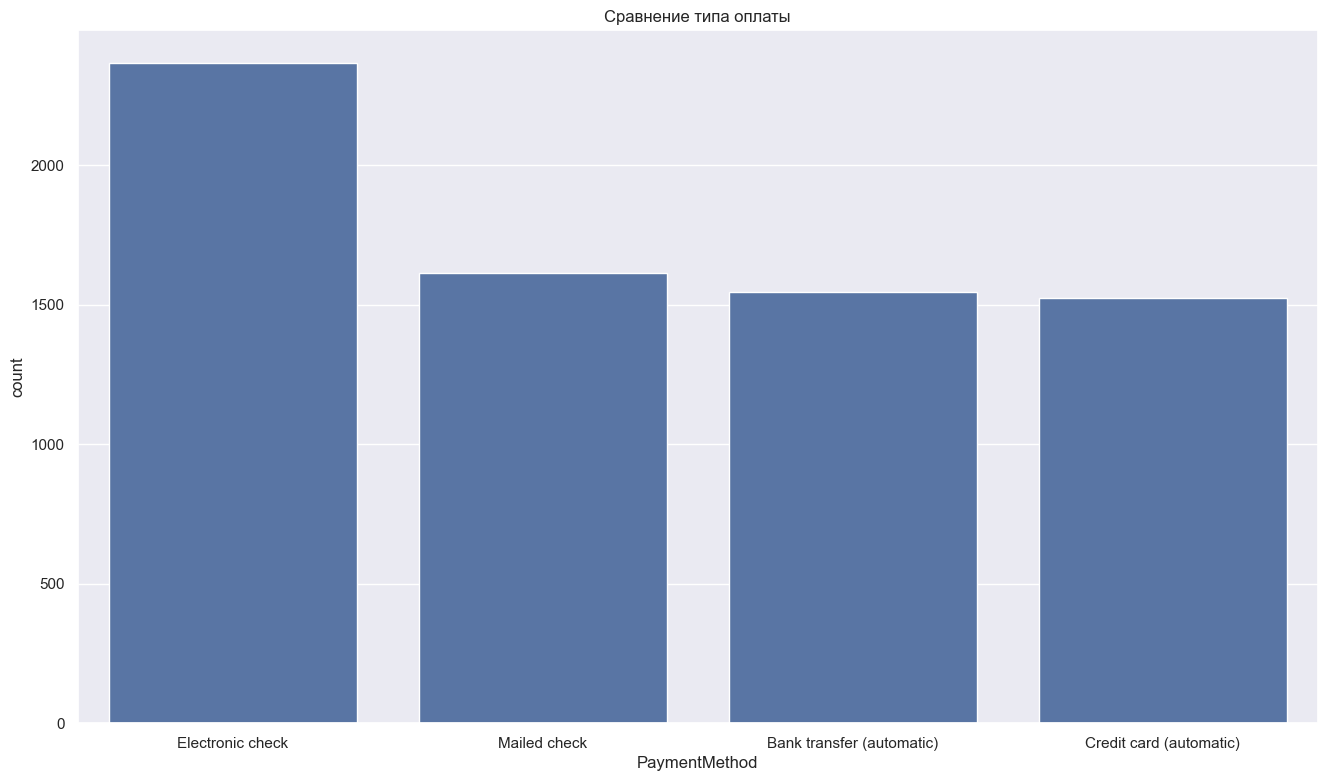

In [23]:
sns.countplot(data=df_contract, x='PaymentMethod')
plt.title('Сравнение типа оплаты')
plt.show()

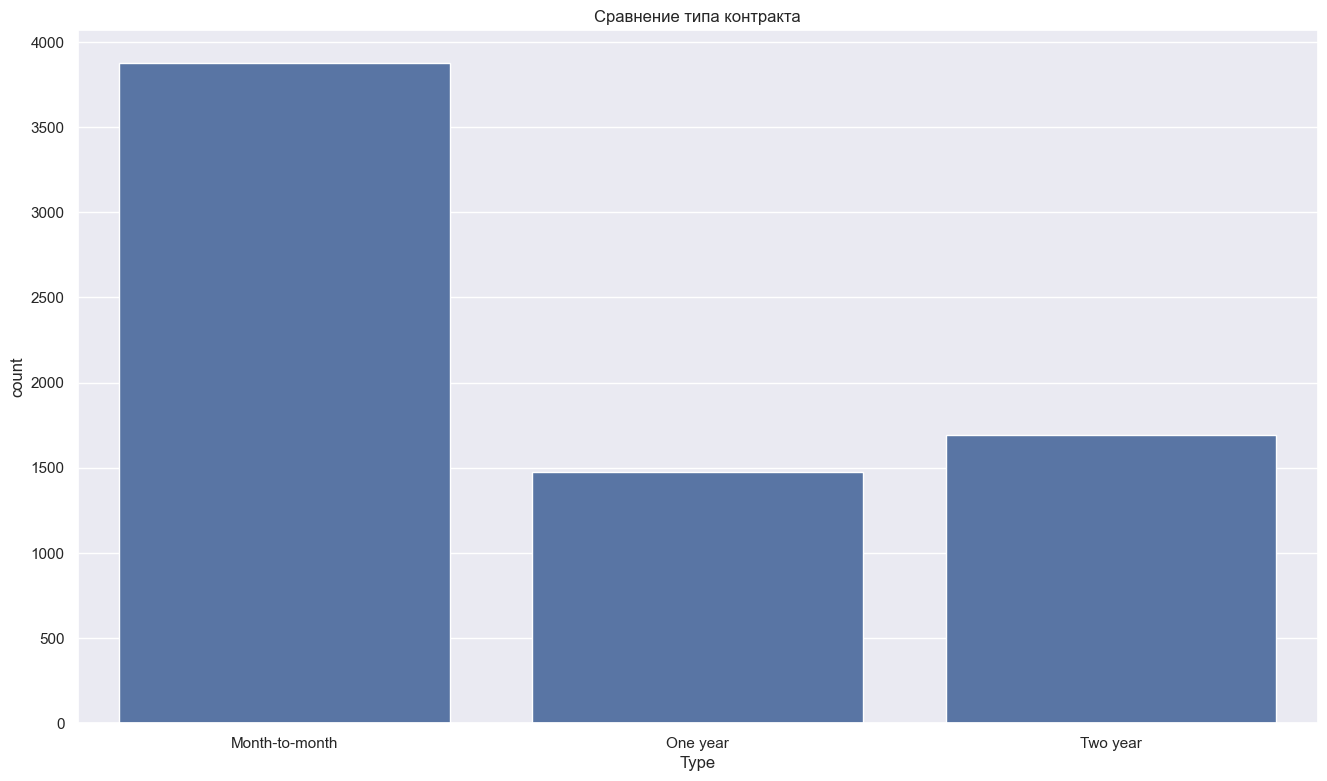

In [24]:
sns.countplot(data=df_contract, x='Type')
plt.title('Сравнение типа контракта')
plt.show()

In [25]:
ind = df_contract[df_contract["TotalCharges"] == ' '].index
df_contract.loc[ind, 'TotalCharges'] = None

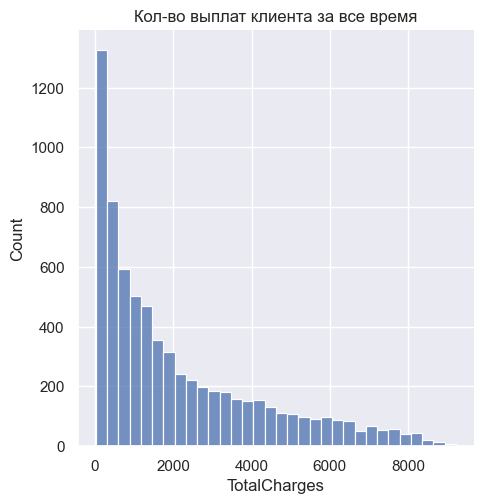

In [26]:
sns.displot(df_contract['TotalCharges'].astype('float'))
plt.title('Кол-во выплат клиента за все время')
plt.show()

Чистые данные, без пропусков. Однако странно что при исользовании `info()` столбец **TotalCharges** имеет тип *object*, хотя при использоовании `display()` на первый взгляд тип данны[] выгляжит как *float*. Как оказалось имеются значения ' ' которых 11 штук и я заменил их на `None`

Топ методов оплат:
1. Electronic check
2. Mailed check
3. Bank transfer (automatic)

Самые популярный тип контракта - **Month-to-month**

### 2.2 Персональная информация

In [27]:
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


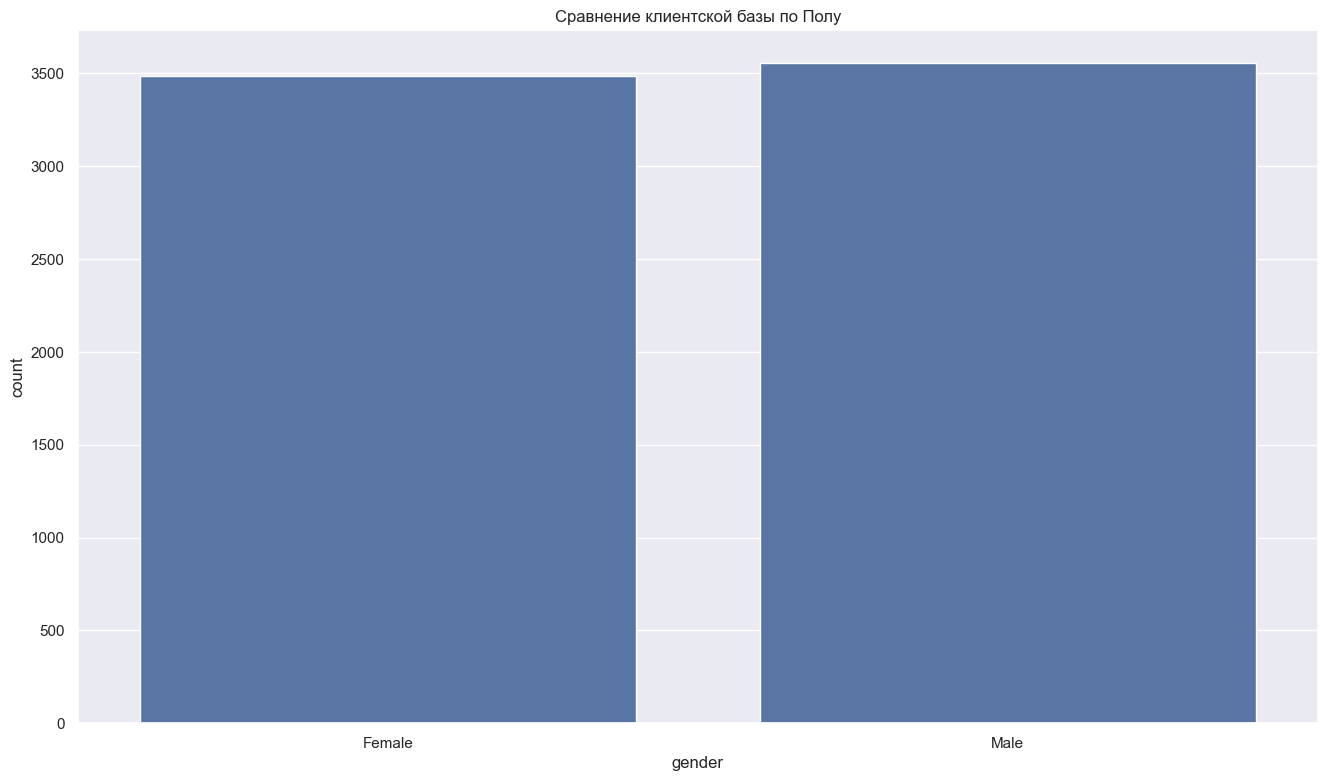

Процент мужчин в клиентской базе 50.5%


C:\Users\monov\AppData\Local\Temp\ipykernel_23888\525870590.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  male_percent = round(df_personal["gender"].value_counts(normalize=True)[0] * 100, 1)


In [28]:
sns.countplot(data=df_personal, x='gender')
plt.title('Сравнение клиентской базы по Полу')
plt.show()
male_percent = round(df_personal["gender"].value_counts(normalize=True)[0] * 100, 1)
print(f'Процент мужчин в клиентской базе {male_percent}%')

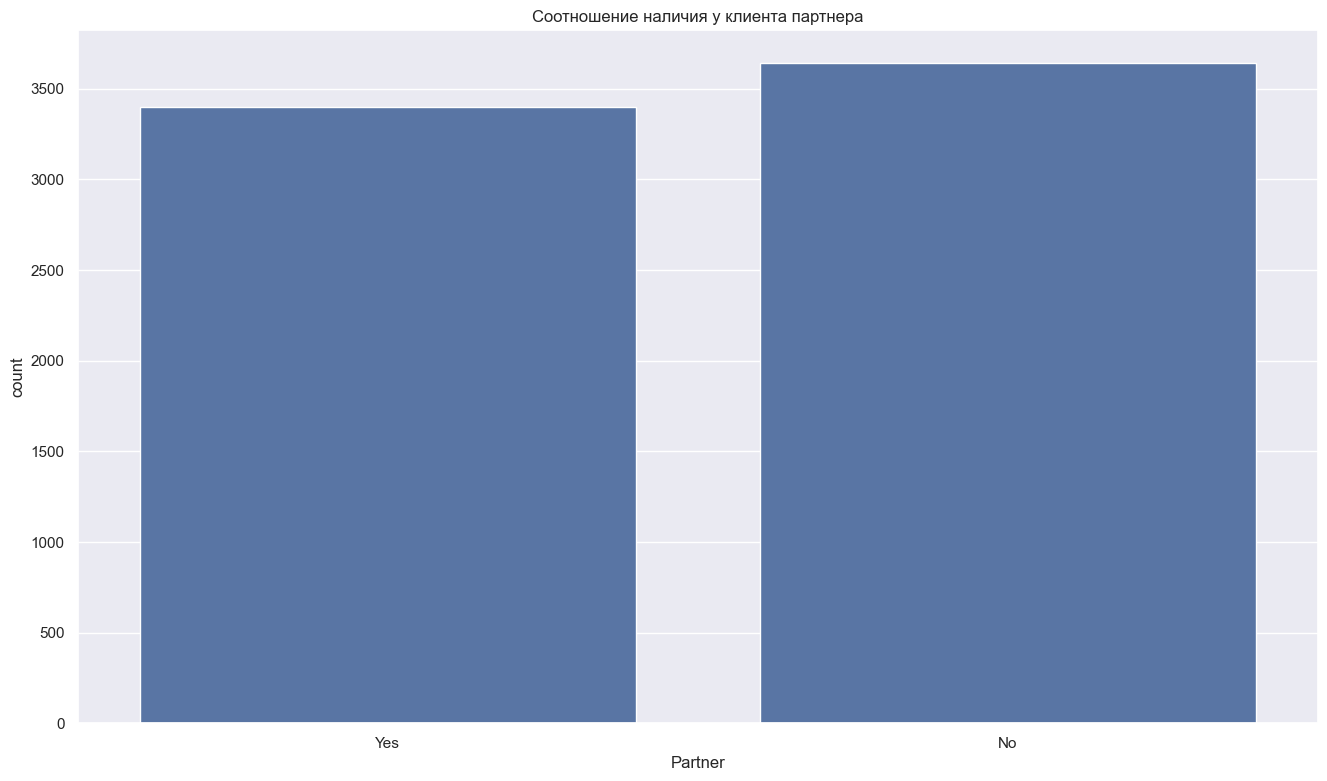

Наличие партнера у 48.3%


C:\Users\monov\AppData\Local\Temp\ipykernel_23888\893019998.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  partner_percent = round(df_personal["Partner"].value_counts(normalize=True)[1] * 100, 2)


In [29]:
sns.countplot(data=df_personal, x='Partner')
plt.title('Соотношение наличия у клиента партнера')
plt.show()
partner_percent = round(df_personal["Partner"].value_counts(normalize=True)[1] * 100, 2)
print(f'Наличие партнера у {partner_percent}%')

Чистые данные без пропусков

### 2.3 Информация по услугам

In [30]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


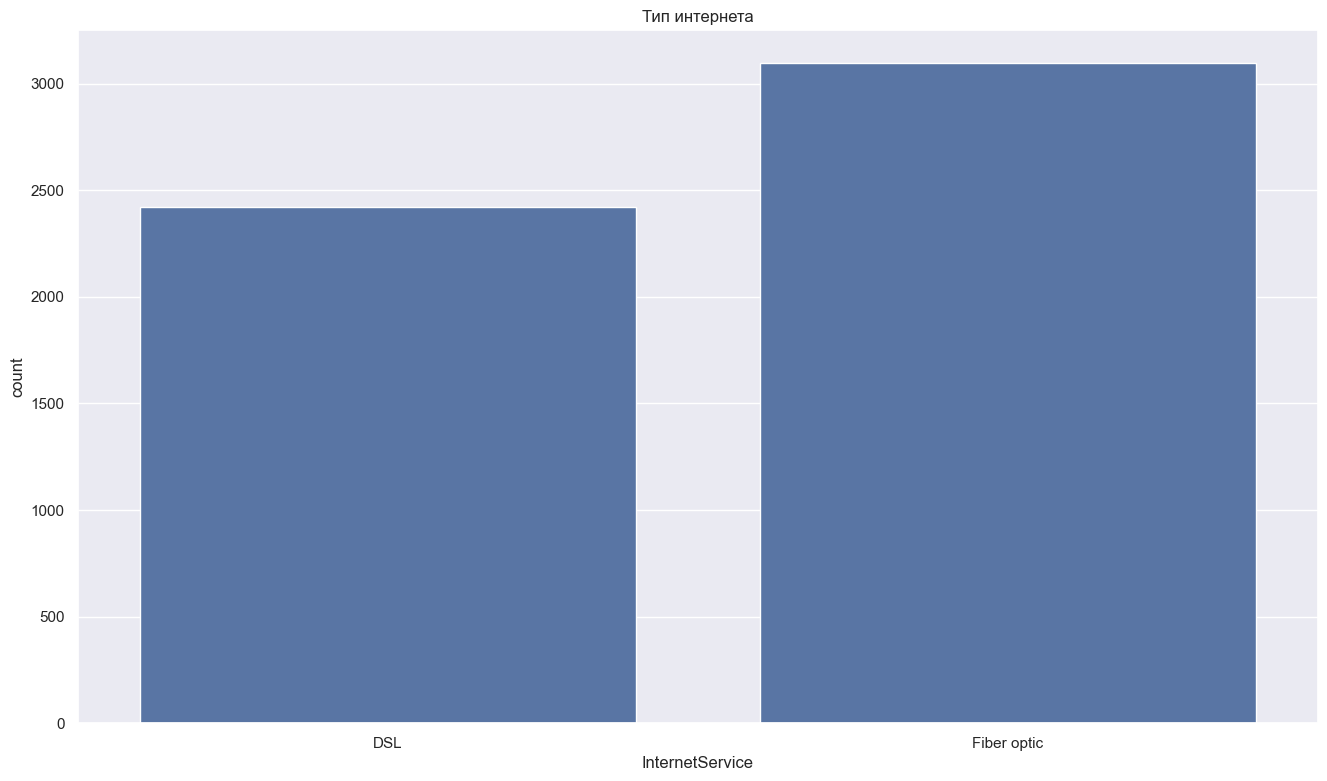

Процент людей которые используют тип интернета "Fiber optic": 56.1%


In [31]:
sns.countplot(data=df_internet, x='InternetService')
plt.title('Тип интернета')
plt.show()
fiber = df_internet["InternetService"].value_counts(normalize=True)["Fiber optic"]
print(f'Процент людей которые используют тип интернета "Fiber optic": {round(fiber * 100, 1)}%')

Процент использования типа интернета *Fiber Optic* - 56.1%

### 2.4 Информация по телефоным линиям

In [32]:
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


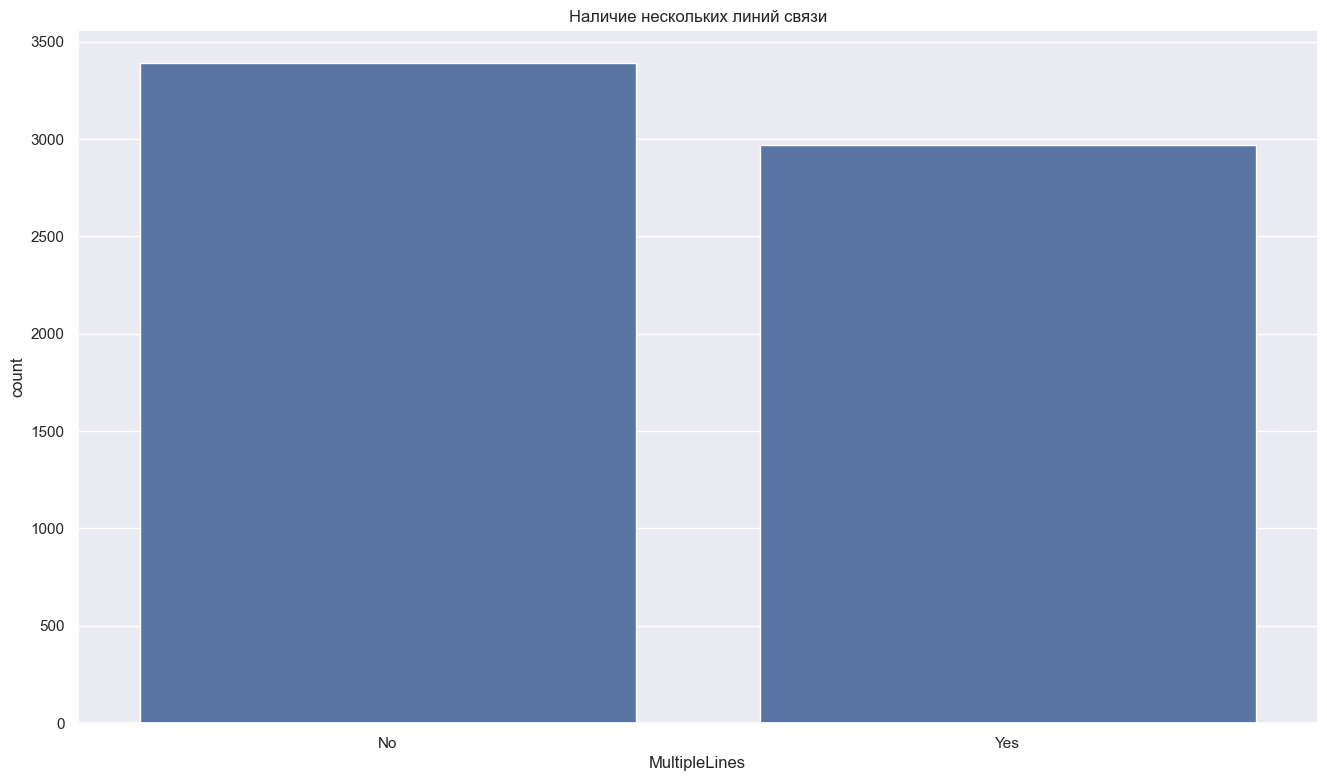

Процент наличия нескольких линий: 46.7%


In [33]:
sns.countplot(data=df_phone, x='MultipleLines')
plt.title('Наличие нескольких линий связи')
plt.show()
MultipleLines = round(df_phone['MultipleLines'].value_counts(normalize=True)['Yes'] * 100, 1)
print(f"Процент наличия нескольких линий: {MultipleLines}%")

У 53.3 процентов людей всего одна линия связи

## 3 Исследования

In [34]:
# Соеденияю все таблицы
df = (
    df_contract
        .join(df_internet ,how='left', rsuffix='_').drop('customerID_', axis=1)
        .join(df_personal, how='left', rsuffix='_').drop('customerID_', axis=1)
        .join(df_phone, how='left', rsuffix='_').drop('customerID_', axis=1)
 )
display(df.head())
print('Количество пропусков по столбцам')
df.isna().sum()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,Yes
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,Female,0,No,No,Yes


Количество пропусков по столбцам


customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

In [35]:
print(f"Процент оставшихся данных если убрать все значения Nan: {round((df.dropna().shape[0] / df.shape[0]) * 100, 1)}%")

Процент оставшихся данных если убрать все значения Nan: 78.2%


In [36]:
df_left = df.query("EndDate != 'No'")
# Сортирую данные что бы остались только записи с клиентами которые ушли
df_dates = pd.DataFrame()
df_dates['Begin'] = pd.to_datetime(df_left['BeginDate'], format='%Y-%m-%d') # Перевожу данные из типа str в datetime
df_dates['End'] = pd.to_datetime(df_left['EndDate'], format='%Y-%m-%d') # Перевожу данные из типа str в datetime
df_dates['diff'] = (df_dates['End'] - df_dates['Begin']).dt.days # Нахожу через сколько дней клиенты разорвали контракт
df_dates.head()

,Begin,End,diff
9,2014-12-01,2017-05-01,882
15,2014-05-01,2016-03-01,670
25,2017-08-01,2018-09-01,396
30,2014-03-01,2018-11-01,1706
35,2014-02-01,2018-12-01,1764


In [37]:
df_dates['diff'].describe().drop('count')
# Информация по данным

mean     924.863760
std      458.771309
min       28.000000
25%      577.000000
50%      915.000000
75%     1249.000000
max     2129.000000
Name: diff, dtype: float64

В среднем клиенты уходят через 915 дней

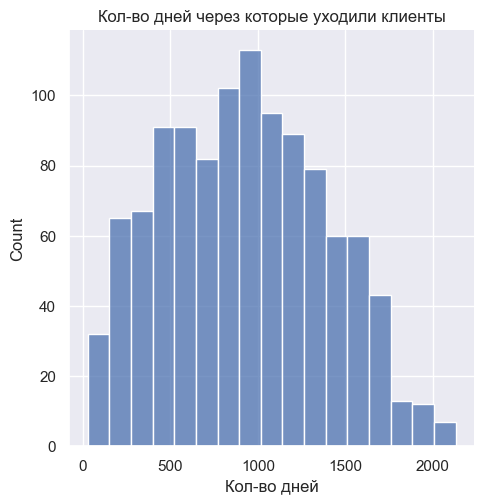

In [38]:
sns.displot(df_dates['diff'])
plt.xlabel('Кол-во дней')
plt.title('Кол-во дней через которые уходили клиенты')
plt.show()

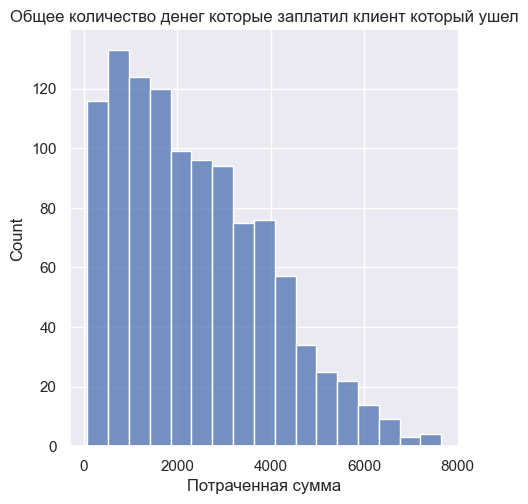

In [39]:
sns.displot(df_left['TotalCharges'].astype(float))
plt.title("Общее количество денег которые заплатил клиент который ушел")
plt.xlabel("Потраченная сумма")
plt.show()

In [40]:
df_left['TotalCharges'].astype(float).describe().drop('count')

mean    2371.377275
std     1581.862275
min       77.840000
25%     1048.050000
50%     2139.030000
75%     3404.910000
max     7649.760000
Name: TotalCharges, dtype: float64

В среднем перед клиенты тратили 2,139 перед тем как ушли 

In [41]:
df_loyal = df.query('EndDate == "No"').copy()
df_loyal['EndDate'] = datetime(2020, 2, 1)
df_loyal['BeginDate'] = pd.to_datetime(df_loyal['BeginDate'], format='%Y-%m-%d')
df_loyal['diff'] = (df_loyal['EndDate'] - df_loyal['BeginDate']).dt.days
df_loyal.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,diff
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,Yes,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,...,No,No,No,No,Female,0,No,No,Yes,153


In [42]:
df_loyal['diff'].describe().drop('count')

mean     893.681084
std      716.958551
min        0.000000
25%      245.000000
50%      702.000000
75%     1523.000000
max     2314.000000
Name: diff, dtype: float64

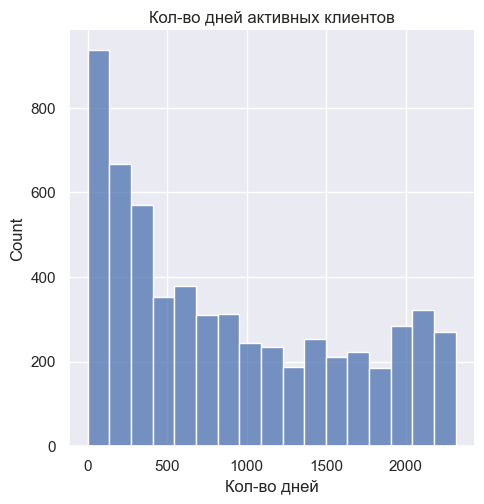

In [43]:
sns.displot(df_loyal['diff'])
plt.xlabel('Кол-во дней')
plt.title('Кол-во дней активных клиентов')
plt.show()

In [44]:
df_loyal['TotalCharges'].astype(float).describe().drop('count')

mean    2071.701614
std     2194.122190
min       19.050000
25%      376.225000
50%     1194.280000
75%     3176.000000
max     9221.380000
Name: TotalCharges, dtype: float64

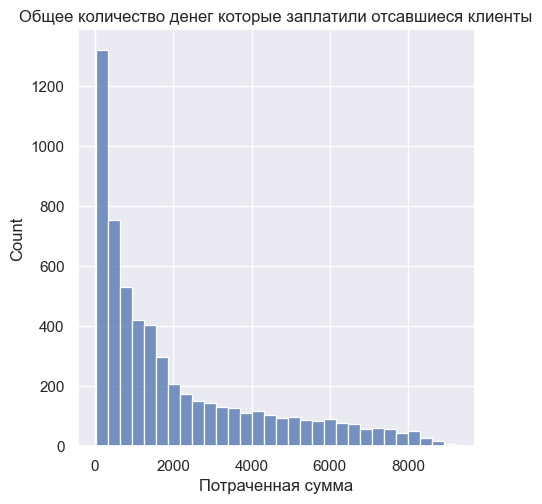

In [45]:
sns.displot(df_loyal['TotalCharges'].astype(float))
plt.title("Общее количество денег которые заплатили отсавшиеся клиенты")
plt.xlabel("Потраченная сумма")
plt.show()

Выводы:
- В среднем время с компаней у активных клиентов - 702 дня
- Средняя потраченная сумма - 1194

## 4. Заключение

Вопросы:

- Как поступить с пропусками после присоединения всех таблиц? 
    - Если заменить, то какой логики придерживаться?
    - Если убрать, то потеряется 22%. Много ли это? Будет ли это критично в дальнейшем?
- Классификатором будет являться наличие даты в столбце *EndDate*?

## Модели

In [46]:
# Создаю копию датафрейма для подготовки данных
df_prep = df.copy()
# Создаю классификатор
df_prep['target'] = df_prep.apply(lambda x: 0 if x['EndDate'] == 'No' else 1, axis=1)

In [47]:
# Ставлю актуальную дату что бы найти длительность контракта в днях
df_prep['EndDate'] = df_prep.apply(lambda x: '2020-02-01' if x['EndDate'] == 'No' else x['EndDate'], axis=1)

In [48]:
# Перевожу столбцы из str в datetime
df_prep['BeginDate'] = pd.to_datetime(df_prep['BeginDate'], format='%Y-%m-%d')
df_prep['EndDate'] = pd.to_datetime(df_prep['EndDate'], format='%Y-%m-%d')

In [49]:
# Нахожу длительность контракта
df_prep['diff_days'] = df_prep.apply(lambda x: x['EndDate'] - x['BeginDate'], axis=1).dt.days

In [50]:
# Заполняю пропуски
fill_cols = ['InternetService'
         , 'OnlineSecurity'
         , 'OnlineBackup'
         , 'DeviceProtection'
         , 'TechSupport'
         , 'StreamingTV'
         , 'StreamingMovies'
         , 'MultipleLines'
         ]
df_prep[fill_cols] = df_prep[fill_cols].fillna('Not used')

In [51]:
df_prep['TotalCharges'] = df_prep['TotalCharges'].fillna(df_prep['MonthlyCharges'] * round(df_prep['diff_days'] / 30, 0))

Не могу узнать точное кол-во трат, но зная кол-во дней клиента с компанией и плату за месяц могу, предположительно рассчитать траты за все время

diff_days (время клиента с компанией в днях) / 30 = месяцев с компанией

месяцы с компанией * ежемесячную плату = предположительные траты клиента

In [52]:
df_prep['TotalCharges'] = df_prep['TotalCharges'].astype(float)

In [53]:
df_prep.info()
df_prep.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,diff_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,Female,0,Yes,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,...,Yes,No,No,Male,0,No,No,Yes,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,...,No,No,No,Female,0,No,No,Yes,0,153


In [54]:
df_prep['target'].value_counts(normalize=True)

target
0    0.843675
1    0.156325
Name: proportion, dtype: float64

Наблюдается сильный дисбаланс классов, 84% c классом *0*, 16 с классом *1*

## Корреляция

In [55]:
phik_matrix(df_prep.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
            , interval_cols=['MonthlyCharges', 'TotalCharges', 'diff_days']
            )

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,diff_days
Type,1.000000,0.106860,0.277462,0.388266,0.470860,0.063434,0.000000,0.000000,0.000000,0.035059,0.075085,0.014170,0.000000,0.086231,0.179736,0.147680,0.000000,0.094015,0.634155
PaperlessBilling,0.106860,1.000000,0.370495,0.467783,0.201703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.242133,0.013218,0.172593,0.000000,0.083398,0.026799
PaymentMethod,0.277462,0.370495,1.000000,0.399536,0.335666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.292725,0.243008,0.224903,0.011925,0.214832,0.350964
MonthlyCharges,0.388266,0.467783,0.399536,1.000000,0.711035,0.000000,0.000000,0.000000,0.000000,0.003184,0.000000,0.000000,0.009025,0.304691,0.203237,0.184213,0.028295,0.225925,0.387579
TotalCharges,0.470860,0.201703,0.335666,0.711035,1.000000,0.012002,0.000000,0.000000,0.000000,0.032761,0.000000,0.000000,0.000000,0.135650,0.381958,0.084247,0.000000,0.302890,0.848337
InternetService,0.063434,0.000000,0.000000,0.000000,0.012002,1.000000,0.949498,0.942842,0.942811,0.948914,0.946713,0.946294,0.000000,0.000000,0.000000,0.000000,0.779233,0.000000,0.000000
OnlineSecurity,0.000000,0.000000,0.000000,0.000000,0.000000,0.949498,1.000000,0.947224,0.946787,0.952651,0.943082,0.943248,0.004351,0.000000,0.000000,0.000701,0.779311,0.000000,0.000000
OnlineBackup,0.000000,0.000000,0.000000,0.000000,0.000000,0.942842,0.947224,1.000000,0.947487,0.947756,0.945789,0.945395,0.000000,0.000000,0.000000,0.000000,0.779200,0.000000,0.000000
DeviceProtection,0.000000,0.000000,0.000000,0.000000,0.000000,0.942811,0.946787,0.947487,1.000000,0.950247,0.952863,0.953717,0.000000,0.000000,0.000000,0.000000,0.779211,0.005480,0.000000
TechSupport,0.035059,0.000000,0.000000,0.003184,0.032761,0.948914,0.952651,0.947756,0.950247,1.000000,0.946393,0.946417,0.010291,0.005750,0.000000,0.000000,0.779247,0.000000,0.000000


Есть проблемы с мультиколлениарностью с которыми я справлюсь в будущем убрав лишние столбцы

## Кодирование признаков

In [56]:
drop = [
    'customerID'
    , 'BeginDate'
    , 'EndDate'
    , 'target'
    , 'OnlineSecurity'
    , 'TechSupport'
    , 'StreamingMovies'
    , 'Dependents'
    , 'MonthlyCharges'
    , 'PaperlessBilling'
    , 'PaymentMethod'
    , 'TotalCharges'
]
x = df_prep.drop(drop, axis=1)
y = df_prep['target']

In [57]:
x_train_prep, x_test_prep, y_train, y_test = train_test_split(
    x, y, train_size=.75, random_state=RANDOM_STATE)

In [58]:
category_cols = list(df_prep
                .drop(drop, axis=1)
                .select_dtypes('object')
                .columns)

x_train_cat = x_train_prep[category_cols]
x_test_cat = x_test_prep[category_cols]

x_train_num = x_train_prep.drop(category_cols, axis=1)
x_test_num = x_test_prep.drop(category_cols, axis=1)

# OneHotEncoder
encoder = OrdinalEncoder()#handle_unknown='ignore')

In [59]:
x_train_encoded = encoder.fit_transform(x_train_cat)
x_test_encoded = encoder.transform(x_test_cat)

In [60]:
# StandardScaler
scaler = StandardScaler()
x_train_num_encoded = scaler.fit_transform(x_train_num)
x_test_num_encoded = scaler.transform(x_test_num)

In [61]:
# Соединяю данные
x_train = np.concatenate([x_train_encoded, x_train_num_encoded], axis=1)
x_test = np.concatenate([x_test_encoded, x_test_num_encoded], axis=1)

In [62]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

## Обучение модели

In [63]:
# Параметры для моделей для GridSearchCV
grid_settings = {
    'CatBoostClassifier': (
        CatBoostClassifier(random_state=RANDOM_STATE, silent=True, class_weights=class_weights),
        {
            'n_estimators': [i for i in range(150, 301, 50)]
            , 'depth': [i for i in range(3, 7)]
            , 'learning_rate': [.1, .2]
        } 
        )
    , 'LGBMClassifier': (
        LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, class_weight=class_weights),
        {
            'n_estimators': [i for i in range(150, 301, 50)]
            , 'max_depth': [-1, 3, 4]
            , 'learning_rate': [.1, .2]
        } 
        )
    , 'RandomForestClassifier': (
        RandomForestClassifier(random_state=RANDOM_STATE, class_weight=class_weights),
        {
            'n_estimators': [i for i in range(150, 401, 50)]
            , 'max_depth': [None] + [i for i in range(3,6)]
        }
        )
    , 'DecisionTreeClassifier': (
        DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight=class_weights),
        {
            'max_depth': [i for i in range(3, 6)]
            , 'min_samples_leaf': [i for i in range(2, 5)]
        }
                        )
}

LightGBMError: scikit-learn is required for lightgbm.sklearn. You must install scikit-learn and restart your session to use this module.

## GridSearchCV

In [ ]:
%%time
for model_name, (model, settings) in grid_settings.items():
    search = GridSearchCV(estimator=model
                          , param_grid=settings
                          , scoring='roc_auc'
                          , cv=3
                          , n_jobs=-1
                          , verbose=10
                         )
    search.fit(x_train, y_train)
    print(f'Best params for {model_name}')
    print(search.best_params_)
    print(f'Best roc_auc_score: {round(search.best_score_, 2)}')
    print()

Fitting 3 folds for each of 32 candidates, totalling 96 fits


Best params for CatBoostClassifier
{'depth': 3, 'learning_rate': 0.2, 'n_estimators': 300}
Best roc_auc_score: 0.92

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for LGBMClassifier
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Best roc_auc_score: 0.89

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for RandomForestClassifier
{'max_depth': 5, 'n_estimators': 200}
Best roc_auc_score: 0.79

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params for DecisionTreeClassifier
{'max_depth': 5, 'min_samples_leaf': 3}
Best roc_auc_score: 0.77

CPU times: total: 12.2 s
Wall time: 1min 26s


Лучшая модель - `CatBoostClassifier`:
- roc_auc_score - 0.92

Лучшие гиперпараметры:
- n_estimators - 300
- depth - 4
- learning_rate - 0.2

In [ ]:
model = CatBoostClassifier(learning_rate=.2, depth=3, n_estimators=300
                           , silent=True, class_weights=class_weights)
model.fit(x_train, y_train)
print('Feature Importance')
print(pd.Series(model.feature_importances_, index=x.columns))

Feature Importance
Type                 3.571133
InternetService      0.495959
OnlineBackup         1.194729
DeviceProtection     0.983664
StreamingTV          0.875667
gender               0.411607
SeniorCitizen        1.345387
Partner              0.437266
MultipleLines        0.946874
diff_days           89.737713
dtype: float64


In [ ]:
pred = model.predict(x_test)
print('Scores')
print(f'Accuracy_score {round(accuracy_score(y_test, pred), 4)}')
print(f'Roc_auc_score {round(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]), 4)}')

Scores
Accuracy_score 0.8694
Roc_auc_score 0.912


Метрика Accuracy score показывает процент правильно предсказанных ответов (ушёл клиент или нет). 0.8694 обозначают что модель правильно предсказала ушел клиент или остался в 86.94% случаев

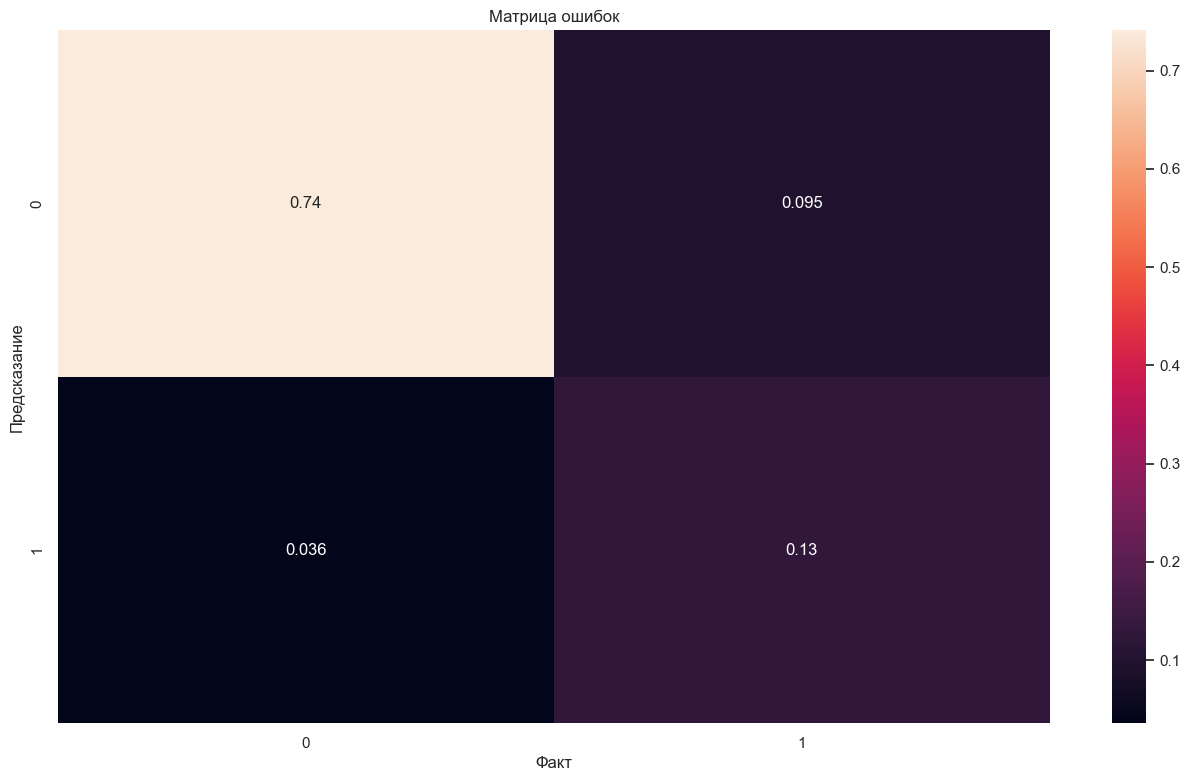

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred) / pred.shape[0], annot=True)
plt.ylabel('Предсказание')
plt.xlabel('Факт')
plt.title('Матрица ошибок')
plt.show()

Самый важный признак - столбец diff_days

Точное описание:

Модель:
- предсказала 0, факт 0 (модель предсказала что клиент остался, фактически он остался). Таких правильных предсказаний большинство (74%) так как большинство данных это клиенты которые остались, поэтому модель хорошо эти случаи предсказывает
- предсказала 0, факт 1 (модель предсказала что клиент остался, фактически он ушел). Таких ошибочных предсказаний большинство (9.5%) так как, в данных есть дисбаланс данных (клиентов которые остались больше чем которых ушли), поэтому модель хуже предсказывает случаи с ушедшими клиентами
- предсказала 1, факт 0 (модель предсказала что клиент ушел, фактически он остался). Таких предсказаний меньше всего (3.6%), модель хорошо обучена предсказывать оставшихся клиентов
- предсказала 1, факт 1 (модель предсказала что клиент ушел, фактически он ушел). Таких предсказаний (13%), потому что данных с ушедшими клиентами мало и ситуаций мало, поэтому предсказания редки

Описание для заказчика:

Ключевая задача проекта была помочь компании в предсказании потенциального желания клиента уйти.
На основании ретро-данных была построена модель. 
Однако с учётом того, что доля клиентов сохранивших взаимоотношения с компанией значительно выше, чем расторгнувших контракт, обучающая выборка изначально была существенно больше для оставшихся клиентов. Соответственно качество предсказания клиента остаться в построенной модели выше качества предсказания ухода клиента из компании.
Построенная модель продемонстрировала следующие результаты:
- модель предсказала сохранение клиентов в 1305 случаев, 88,6% предсказание было корректно, в 11,4% - ошибочно, а с точки зрения оценки доли сохранившихся клиентов, от тех кого предсказала модель, она составляет - выше 94%. Исходя из этого можно сделать вывод, что модель с высоким уровнем точности предсказывает вероятность того, что клиент останется в компании, если за базу брать общее количество клиентов.
- модель предсказала уход клиентов в 226 случаев, 78% предсказание было корректно, в 28% - ошибочно, с точки зрения оценки доли ушедших клиентов, от тех кого предсказала модель, она составляет - 60%. Исходя из этого можно сделать вывод, что модель с предсказывает вероятность ухода клиента с более высоким уровнем погрешности.

`roc_auc_score` - 0.91 что достаточно для проекта

`accuracy_score` - 0.88 как показательная метрика

## Заключение

### 1. Определена цель и задачи проекта
1. Обработать данные
    - Соеденить все таблицы
    - Избавиться от Nan (заменить/убрать)
2. Построить модель
    - С помощью энкодеров перевести данные из str в int/float
    - Найти лучшую модель и параметры для нее. Модели которые я собираюсь использовать
    - CatBoostClassifier
    - LGBMClassifier
    - RandomForestClassifier
    - SGDClassifier
3. Оценить модели
4. Сделать выводы

### 2. Анализ соответсвие фактической работы запланированным шагам
- Вся работа соответствовала изначальному плану кроме:
    - решил отказаться от *SGDClassifier* так как он так же представляет модели бустинга. Я решил исользовать *DecisionTreeClassifier* для большего разнообразия алгоритмов 

### 3. Рефлексия над сложностями и описание путей их решения
- Больших сложностей я не встретил
- Из наиболее трудных задач были
    - Поиск логики замены пропусков у клиентов которые не использовали пакет с услугами
        - Создал новое значение для клиентов которые не использовали пакет
    - Поиск логики замены пропусков в столбце отвечающем за общу потраченную сумму клиентом
        - нашел количесво месяцев клиентов с компанией и умножив на ежемесячную плату нашел предположительные траты

### 4. Предобработка данных
- Все таблицы из разных файлов соеденены в единую таблицу
    - Добавлен столбец отвечающий за время клиента с команией в днях ("diff_days")
    - Сформулирован признак классификации проекта
    - Возникли пропуски у клиентов которые не пользовались пакетом услуг
        - Были заменены значением "Not used", что бы показать разницу между исользованием пакета, но не использованием некоторых услуг по сравнению с не использованием пакета совсем
    - Найдены пропуски в столбце "Total Charges" отвечающим за общие траты клиента за все время.
        - Заменил пропуски
            - нашел количество месяцев с компанией клиента
            - умножил на ежемесячную плату
            - получил предположительные траты
- Изменил типы данных в столбцах для правильной работы с данными

### 5. Итоговый список признаков для обучения моделей:

- Список признаков с расшифровкой:
    - Type - тип контракта с клиентом ("Month-to-Month" - ежемесячный, "One Year" - на один год, "Two year" - на два года)
    - InternetService - пользование интернетом
    - OnlineBackup - пользование данной услугой
    - DeviceProtection - пользование данной услугой
    - StreamingTV - пользование услугой TV
    - gender - пол клиента
    - SeniorCitizen - наличие пенсионного статуса по возрасту
    - Partner - наличие партнера у клиента
    - MultipleLines - наличие возможности ведения параллельных линий во время звонка
    - diff_days - времня клиента с компанией в днях
- Способы обработки данных/кодировки/стандартизация/преобразование:
    - Для числовых данных использовался - *StandardScaler*
    - Для категориальных данных исользовался - *OrdinalEncoder*

### 6. Сводная таблица исследованных модолей и их метрика на кросс-валидации

Сводная таблица


,score
CatBoostClassifier,0.92
LGBMClassifier,0.89
RandomForestClassifier,0.79
DecisionTreeClassifier,0.77


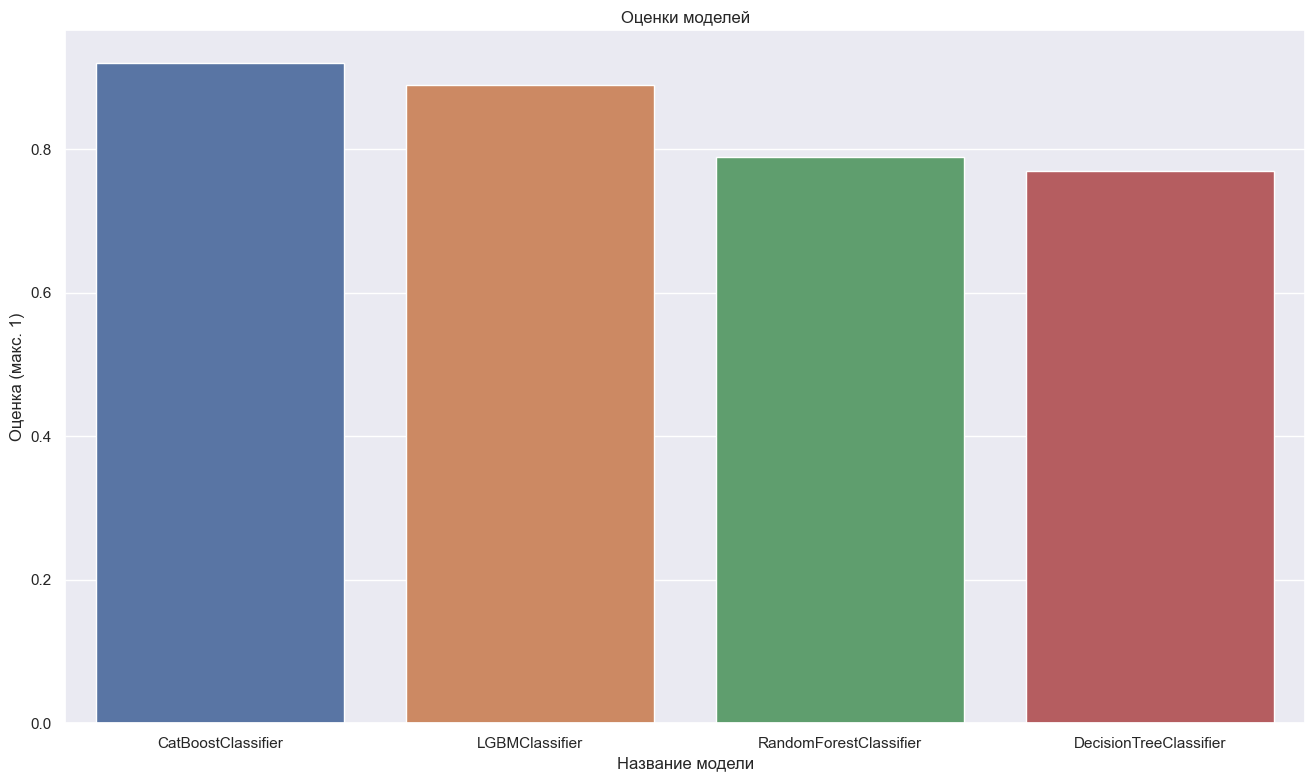

In [ ]:
models_name = ['CatBoostClassifier', 'LGBMClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier']
models_scores =  [.92, .89, .79, .77]
models_summary = pd.DataFrame(models_scores, models_name, columns=['score'])

print('Сводная таблица')
display(models_summary)
print('')
sns.barplot(x=models_summary.index, y=models_summary['score'])
plt.title('Оценки моделей')
plt.xlabel('Название модели')
plt.ylabel('Оценка (макс. 1)')
plt.show()

### 7. Лучше всего себя показала модель - ***CatboostClassifier***, с параметрами:
    - 'depth' = 3
    - 'learning_rate' = 0.2
    - 'n_estimators' = 300
    - AUC_ROC на кросс-валидации - 0.92

### 8. На тестовой выборке модель показала:
 - Accuracy_score =  0.8694
 - Roc_auc_score = 0.912

### 9. Матрица ошибок

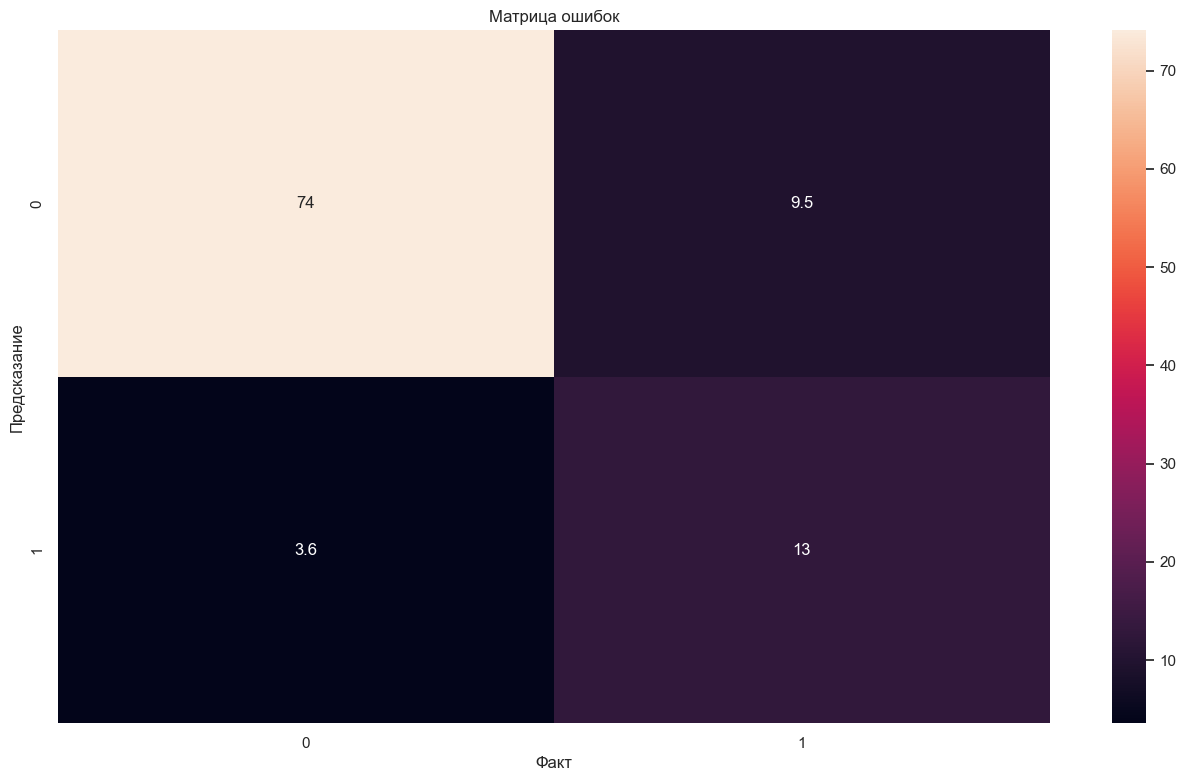

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred) / pred.shape[0] * 100, annot=True)
plt.ylabel('Предсказание')
plt.xlabel('Факт')
plt.title('Матрица ошибок')
plt.show()

Ключевая задача проекта была помочь компании в предсказании потенциального желания клиента уйти.
На основании ретро-данных была построена модель. 
Однако с учётом того, что доля клиентов сохранивших взаимоотношения с компанией значительно выше, чем расторгнувших контракт, обучающая выборка изначально была существенно больше для оставшихся клиентов. Соответственно качество предсказания клиента остаться в построенной модели выше качества предсказания ухода клиента из компании.
Построенная модель продемонстрировала следующие результаты:
- модель предсказала сохранение клиентов в 1305 случаев, 88,6% предсказание было корректно, в 11,4% - ошибочно, а с точки зрения оценки доли сохранившихся клиентов, от тех кого предсказала модель, она составляет - выше 94%. Исходя из этого можно сделать вывод, что модель с высоким уровнем точности предсказывает вероятность того, что клиент останется в компании, если за базу брать общее количество клиентов.
- модель предсказала уход клиентов в 226 случаев, 78% предсказание было корректно, в 28% - ошибочно, с точки зрения оценки доли ушедших клиентов, от тех кого предсказала модель, она составляет - 60%. Исходя из этого можно сделать вывод, что модель с предсказывает вероятность ухода клиента с более высоким уровнем погрешности.

### 10. Важность признаков

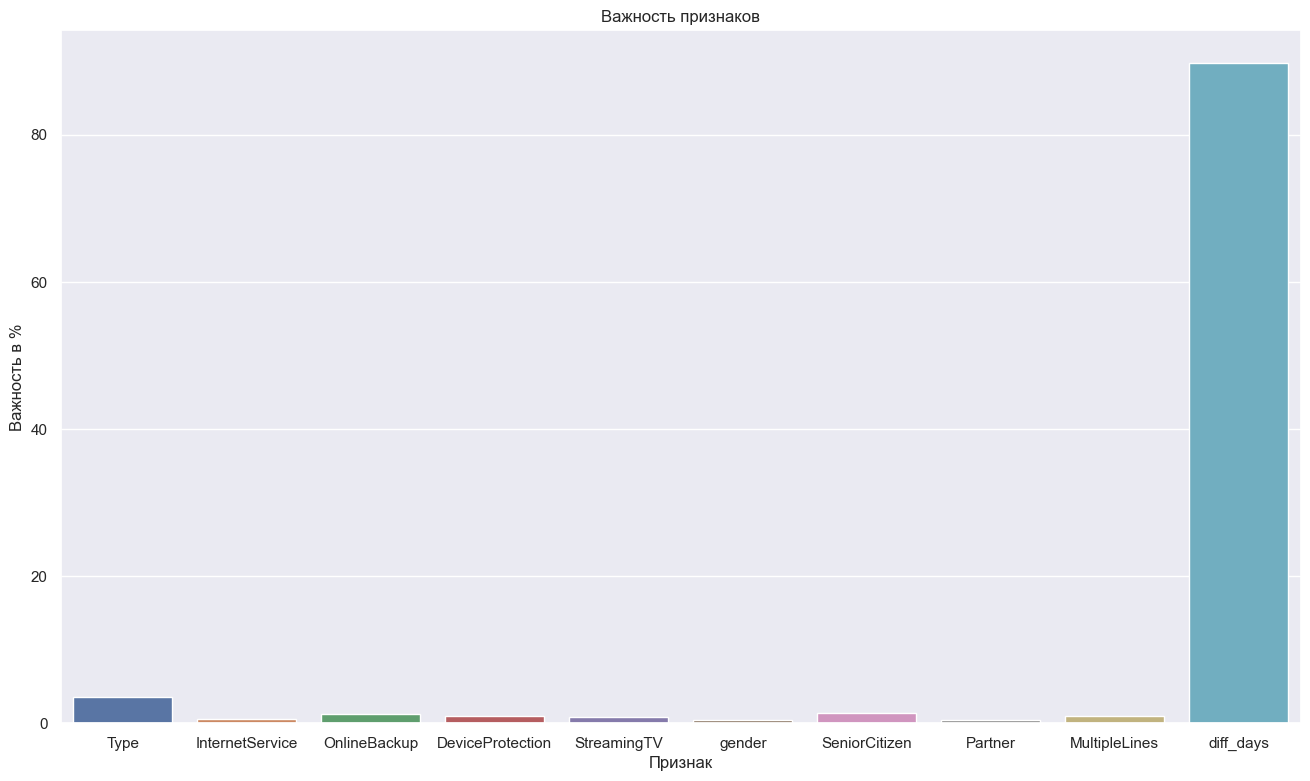

In [ ]:
df_total = pd.DataFrame(model.feature_importances_, index=x.columns)
sns.barplot(x=df_total.index, y=df_total[0])
plt.title('Важность признаков')
plt.xlabel('Признак')
plt.ylabel('Важность в %')
plt.show()

Самый важный признак - diff_days